# Traffic Sign Recognition System

Importing Required Libraires

In [ ]:
import shutil #unzipping file
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import keras
import cv2

from PIL import Image

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

import warnings
warnings.filterwarnings('ignore')

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Verify mount succeeded
print(os.listdir('/content/drive/My Drive/'))

dataset_path = '/content/drive/My Drive/Springboard_Dataset/'

# unzipping the file
!unzip -q '/content/drive/My Drive/Springboard_Dataset/archive.zip' -d /content/Springboard_Data/

# Now use local path (much faster for training)
dataset_path = '/content/Springboard_Data/'

Mounted at /content/drive
['Saving Water English.pptx', 'School', 'Papa', 'ES1-132-C93G_Asus_Aspire ES 11', "Mother's Day.mp4", 'Ahana videos.zip', 'Girish Dandur_Passbook.jpg', 'final publish revised.mp4', 'RUAS', 'Backup_07 02 24', 'Personal Details', 'Cloud_Library', "Tata's Shop", 'Akshat Girish Dandur_Acceptance Letter (3).pdf', 'Akshat Girish Dandur_Acceptance Letter (2).pdf', 'Akshat Girish Dandur_Acceptance Letter (1).pdf', 'Akshat Girish Dandur_Acceptance Letter.pdf', 'Copy of ipu — Mathematics.pdf', 'Internship Certificate_Akshat Girish Dandur_SDST-38453.pdf', 'Q4_E.png', 'New_Setup_Data', 'Classroom', 'Here’s a clear and compelling slide content for “The Solution” — highlighting GreenPlug’s value proposition and how you uniquely solve customer pain points:.gdoc', 'Resume_Template_Draft.docx', 'Colab Notebooks', 'Springboard_Dataset', 'My_CV2.pdf']


Loading the CSV files into DataFrames

In [ ]:
classes = 43
dataset_dir = dataset_path

#Retrieving the images and their labels
metaDF = pd.read_csv('/content/Springboard_Data/Meta.csv')
trainDF = pd.read_csv('/content/Springboard_Data/Train.csv')
testDF = pd.read_csv('/content/Springboard_Data/Test.csv')

ac_labels = ['20 km/h', '30 km/h', '50 km/h', '60km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking', 'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock', 'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light', 'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']

In [ ]:
print('Shape of training set: ', trainDF.shape)
print('Shape of test set: ', testDF.shape)
print('Shape of Meta info: ', metaDF.shape)

Shape of training set:  (39209, 8)
Shape of test set:  (12630, 8)
Shape of Meta info:  (43, 5)


Loading the path

In [ ]:
# updating the dataframes with complete path of the image by adding a new feature called c_path
trainDF['c_path'] = list(map(lambda x: os.path.join(dataset_dir, x.lower()), trainDF['Path']))

testDF['c_path'] = list(map(lambda x: os.path.join(dataset_dir, x.lower()), testDF['Path']))

metaDF['c_path'] = list(map(lambda x: os.path.join(dataset_dir, x.lower()), metaDF['Path']))

In [ ]:
trainDF.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,c_path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png,/content/Springboard_Data/train/20/00020_00000...
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png,/content/Springboard_Data/train/20/00020_00000...
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png,/content/Springboard_Data/train/20/00020_00000...
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png,/content/Springboard_Data/train/20/00020_00000...
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png,/content/Springboard_Data/train/20/00020_00000...


In [ ]:
testDF.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path,c_path
0,53,54,6,5,48,49,16,Test/00000.png,/content/Springboard_Data/test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png,/content/Springboard_Data/test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png,/content/Springboard_Data/test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png,/content/Springboard_Data/test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png,/content/Springboard_Data/test/00004.png


In [ ]:
metaDF.head()

,Path,ClassId,ShapeId,ColorId,SignId,c_path
0,Meta/27.png,27,0,0,1.32,/content/Springboard_Data/meta/27.png
1,Meta/0.png,0,1,0,3.29,/content/Springboard_Data/meta/0.png
2,Meta/1.png,1,1,0,3.29,/content/Springboard_Data/meta/1.png
3,Meta/10.png,10,1,0,3.27,/content/Springboard_Data/meta/10.png
4,Meta/11.png,11,0,0,1.22,/content/Springboard_Data/meta/11.png


**Exploratory Data Analysis**

---

*Analyzing class distribution using histogram*

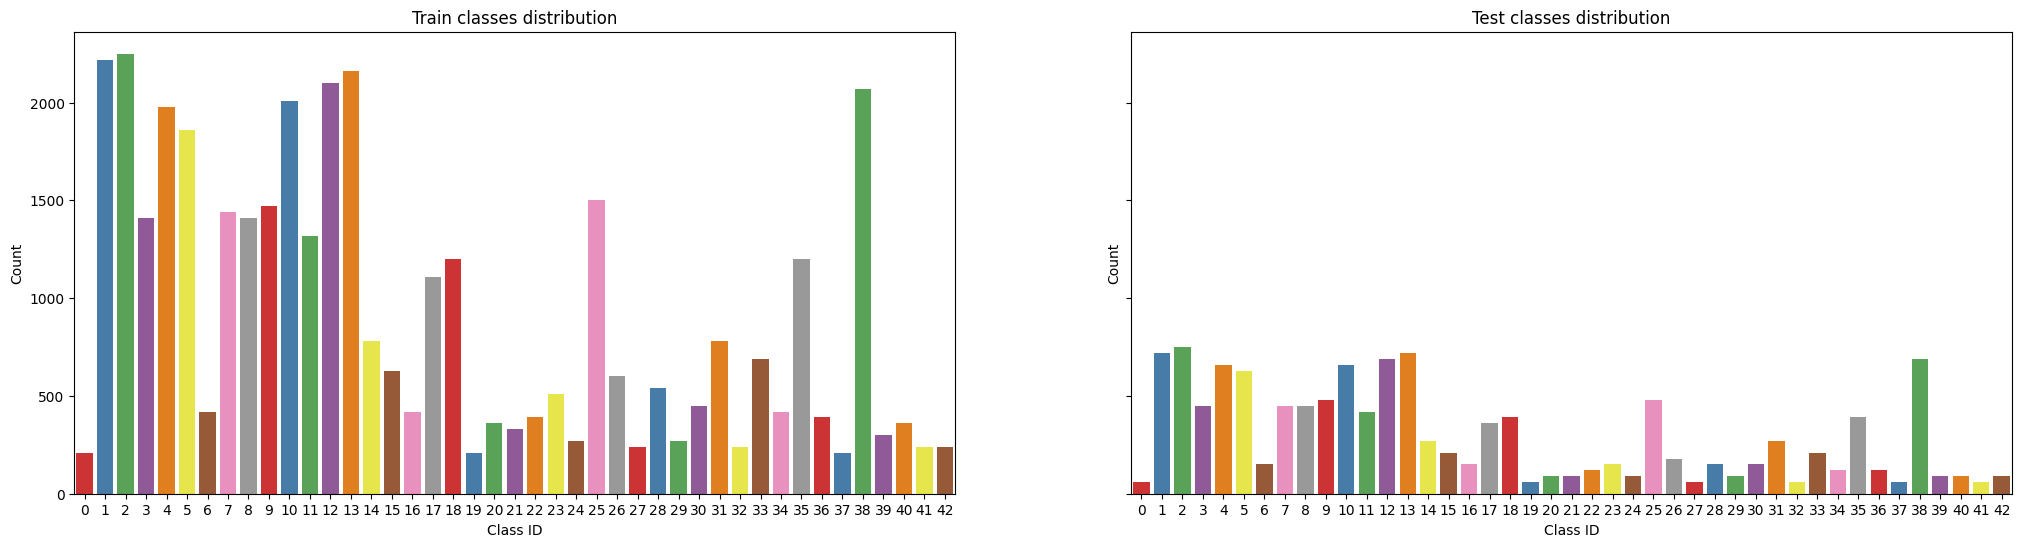

In [ ]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = [25, 6])

axs[0].set_title('Train classes distribution')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')


axs[1].set_title('Test classes distribution')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')


sns.countplot(x='ClassId', data=trainDF, ax=axs[0], palette='Set1', hue='ClassId', legend=False)
sns.countplot(x='ClassId', data=testDF, ax=axs[1], palette='Set1', hue='ClassId', legend=False)
axs[0].set_xlabel('Class ID')
axs[1].set_xlabel('Class ID')
plt.show()

*Analyzing the size distribution plot*

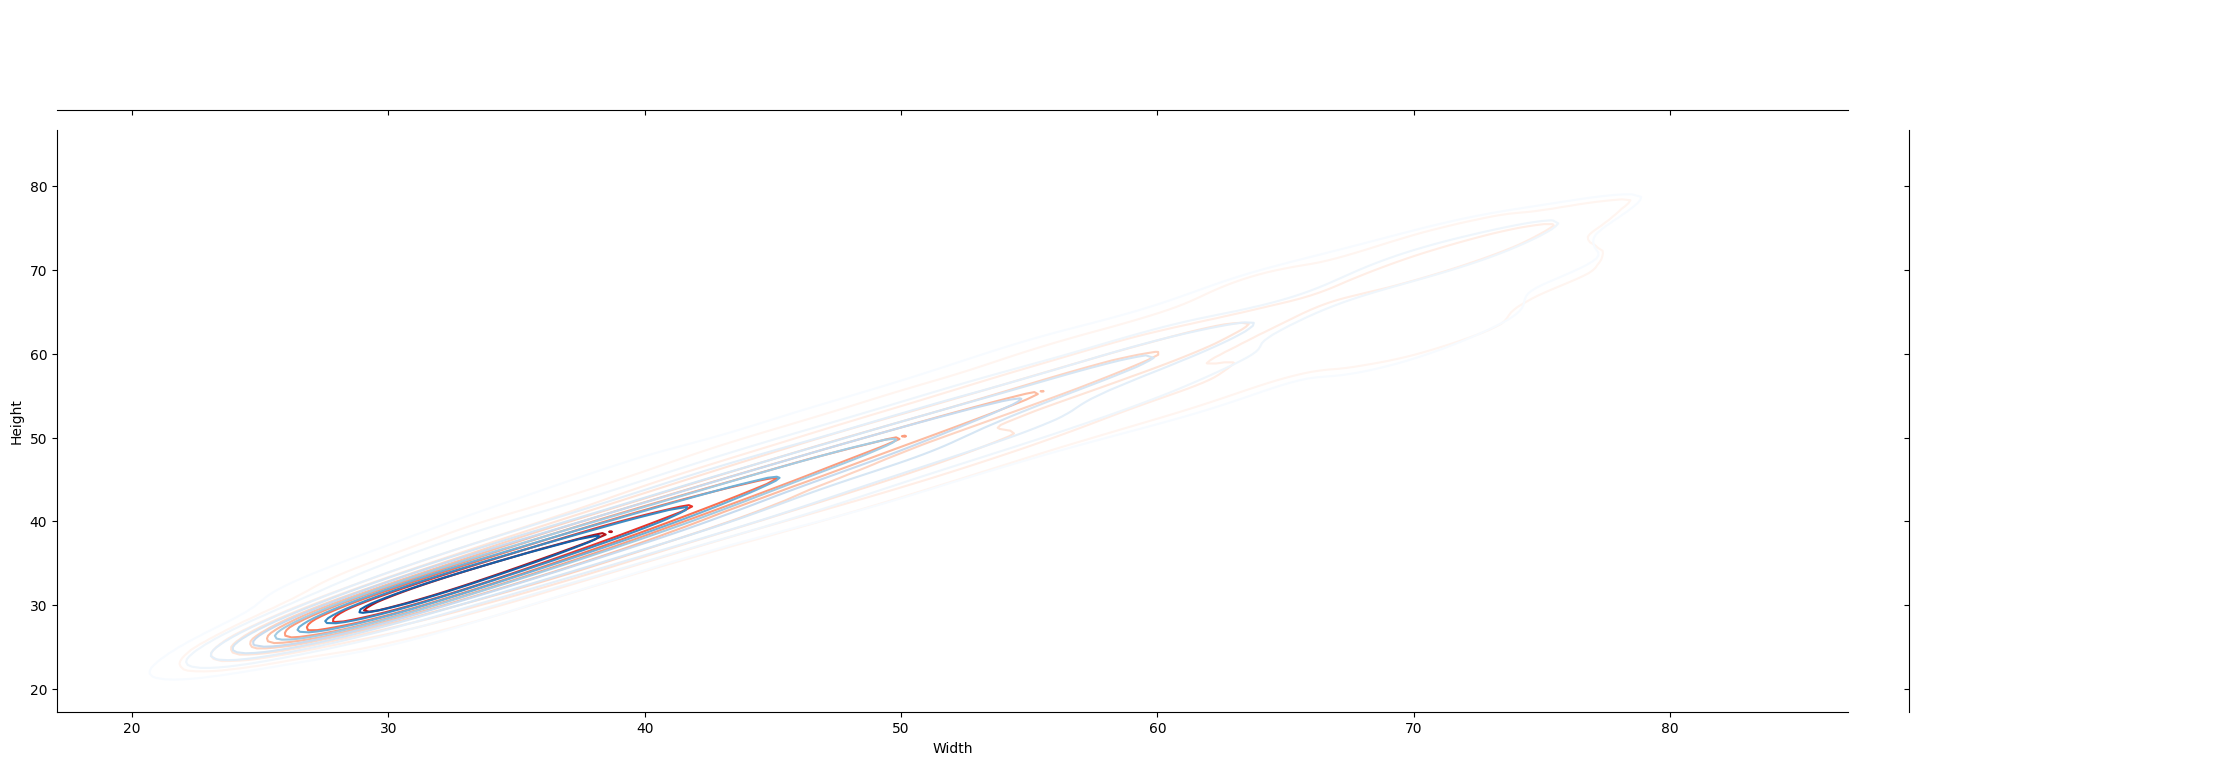

In [ ]:
trainDFDpisubset = trainDF[(trainDF.Width < 80) & (trainDF.Height < 80)];
testDFDpisubset = testDF[(testDF.Width < 80) & (testDF.Height < 80)];

g = sns.JointGrid(x = "Width", y = 'Height', data = trainDFDpisubset)
sns.kdeplot(x=trainDFDpisubset.Width, y=trainDFDpisubset.Height, cmap='Reds', fill=False, ax=g.ax_joint)
sns.kdeplot(x=testDFDpisubset.Width, y=testDFDpisubset.Height, cmap='Blues', fill=False, ax=g.ax_joint)
g.fig.set_figwidth(25)
g.fig.set_figheight(8)
plt.show()

*Visualizing the target class*

In [ ]:
sns.set_style()
rows = 6
cols = 8
fig, axs = plt.subplots(rows, cols, sharex = True, sharey = True, figsize = (225, 50))
plt.subplots_adjust(left = None, right = None, top = 0.9, wspace = None, hspace = None)
metaDF = metaDF.sort_values(by = ['ClassId'])

idx = 0
for i in range(rows):
  for j in range(cols):
    if idx > 42:
      break;

    img = cv2.imread(metaDF["c_path"].tolist()[idx], cv2.IMREAD_UNCHANGED)
    img[np.where(img[:,:,3] == 0)] = [255, 255, 255, 255]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (60, 60))

    axs[i, j].imshow(img)
    axs[i, j].set_facecolor('xkcd:salmon')
    axs[i, j].set_facecolor((1.0, 0.47, 0.42))

    axs[i, j].set_title(ac_labels[int(metaDF["ClassId"].tolist()[idx])])
    axs[i, j].get_xaxis().set_visible(False)
    axs[i, j].get_yaxis().set_visible(False)
    idx += 1

*Preparing the training data for model training*

In [ ]:
data = []
labels = list(trainDF["ClassId"])
images = list(trainDF["c_path"])

for a in images:
  try:
    image = Image.open(a)
    image = image.resize((30, 30))
    image = np.array(image)
    data.append(image)
  except:
    print("Error loading image")

In [ ]:
# Converting lists into numpy arrays
data = np.array(data)
data = data / 255.0
labels = np.array(labels)
print(data.shape)
print(labels.shape)

(39209, 30, 30, 3)
(39209,)


Spliting the training set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


Converting the label using one-hot encoding

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

Defining the CNN model architecture

---

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu', padding = 'same', input_shape = X_train.shape[1:])) # Kernel_size = (5, 5)
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation = 'relu', padding = 'same'))

model.add(MaxPool2D(pool_size = (2, 2))) # Pool_size: (2, 2)
model.add(Dropout(rate = 0.15))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same'))

model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.30))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(43, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 96)       │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 96)       │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,411 (1.73 MB)

 Trainable params: 454,411 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compling the model
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

#defining callback
cb_early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 8, min_delta = 0.02)

epochs = 30
history = model.fit(X_train, y_train, batch_size = 32, epochs = epochs, validation_data = (X_test, y_test), callbacks = [cb_early_stop])

Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 323s 324ms/step - accuracy: 0.1727 - loss: 3.0489 - val_accuracy: 0.8263 - val_loss: 0.5617
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 310s 316ms/step - accuracy: 0.7973 - loss: 0.6298 - val_accuracy: 0.9614 - val_loss: 0.1286
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 322s 317ms/step - accuracy: 0.9221 - loss: 0.2526 - val_accuracy: 0.9813 - val_loss: 0.0603
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 316s 310ms/step - accuracy: 0.9550 - loss: 0.1473 - val_accuracy: 0.9806 - val_loss: 0.0645
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 330s 319ms/step - accuracy: 0.9623 - loss: 0.1246 - val_accuracy: 0.9944 - val_loss: 0.0220
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 330s 328ms/step - accuracy: 0.9730 - loss: 0.0968 - val_accuracy: 0.9938 - val_loss: 0.0216
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 311s 317ms/step - accuracy: 0.9709 - loss: 0.0962 - val_accuracy: 0.9955 - val_loss: 0.0178
Epoch 8/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 321s 316ms/step - accuracy: 0.9755 -

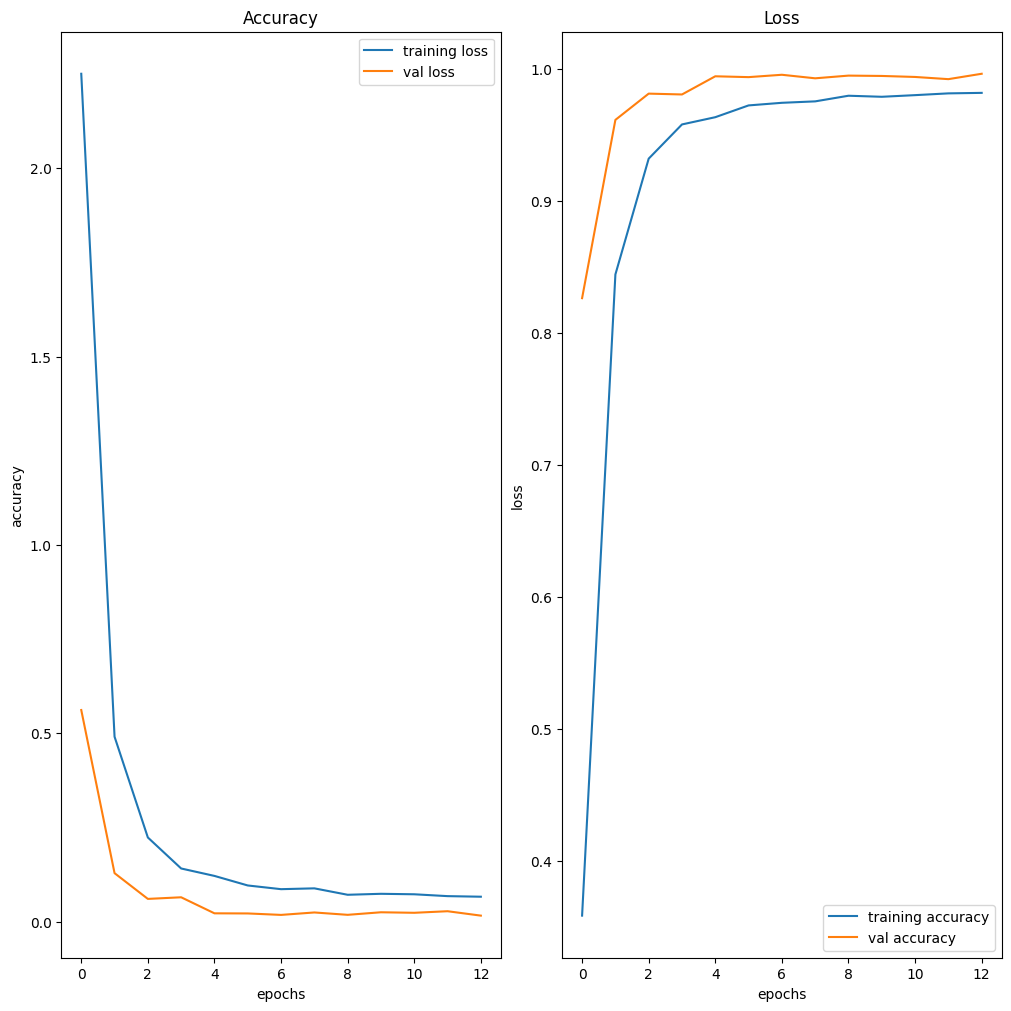

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (10, 10), constrained_layout = True)

axs[0].plot(history.history['loss'], label = 'training loss')
axs[0].plot(history.history['val_loss'], label = 'val loss')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('epochs')
axs[0].set_ylabel('accuracy')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label = 'training accuracy')
axs[1].plot(history.history['val_accuracy'], label = 'val accuracy')
axs[1].set_title('Loss')
axs[1].set_xlabel('epochs')
axs[1].set_ylabel('loss')
axs[1].legend()
plt.show()

In [ ]:
# Loading test data
images = list(testDF['c_path'])
labels = list(testDF['ClassId'])
t_data = []

for a in images:
  try:
    image = Image.open(a)
    image = image.resize((30, 30))
    image = np.array(image)
    t_data.append(image)
  except:
    print("Error loading the image")

In [ ]:
t_data = np.array(t_data)
t_data = t_data / 255.0
labels = np.array(labels)
t_data.shape

(12630, 30, 30, 3)

Evaluating the model on testing data

In [ ]:
pred_probs = model.predict(t_data)
pred = np.argmax(pred_probs, axis=1)

#calculating performance metrics
print(accuracy_score(labels, pred))

395/395 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step
0.966270783847981


In [ ]:
def plot_cm(cm, text):
    class_names = ac_labels
    plot_confusion_matrix(conf_mat = cm,
                          colorbar = True,
                          figsize = (60, 30),
                          cmap = 'Greens',
                          show_absolute = False,
                          show_normed = True)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation = 90, fontsize = 16)
    plt.yticks(tick_marks, class_names, fontsize = 16),
    plt.xlabel('Predicted label', fontsize = 18)
    plt.ylabel('True label', fontsize = 18)
    plt.title(text, fontsize = 19, weight = 'bold')
    plt.show()

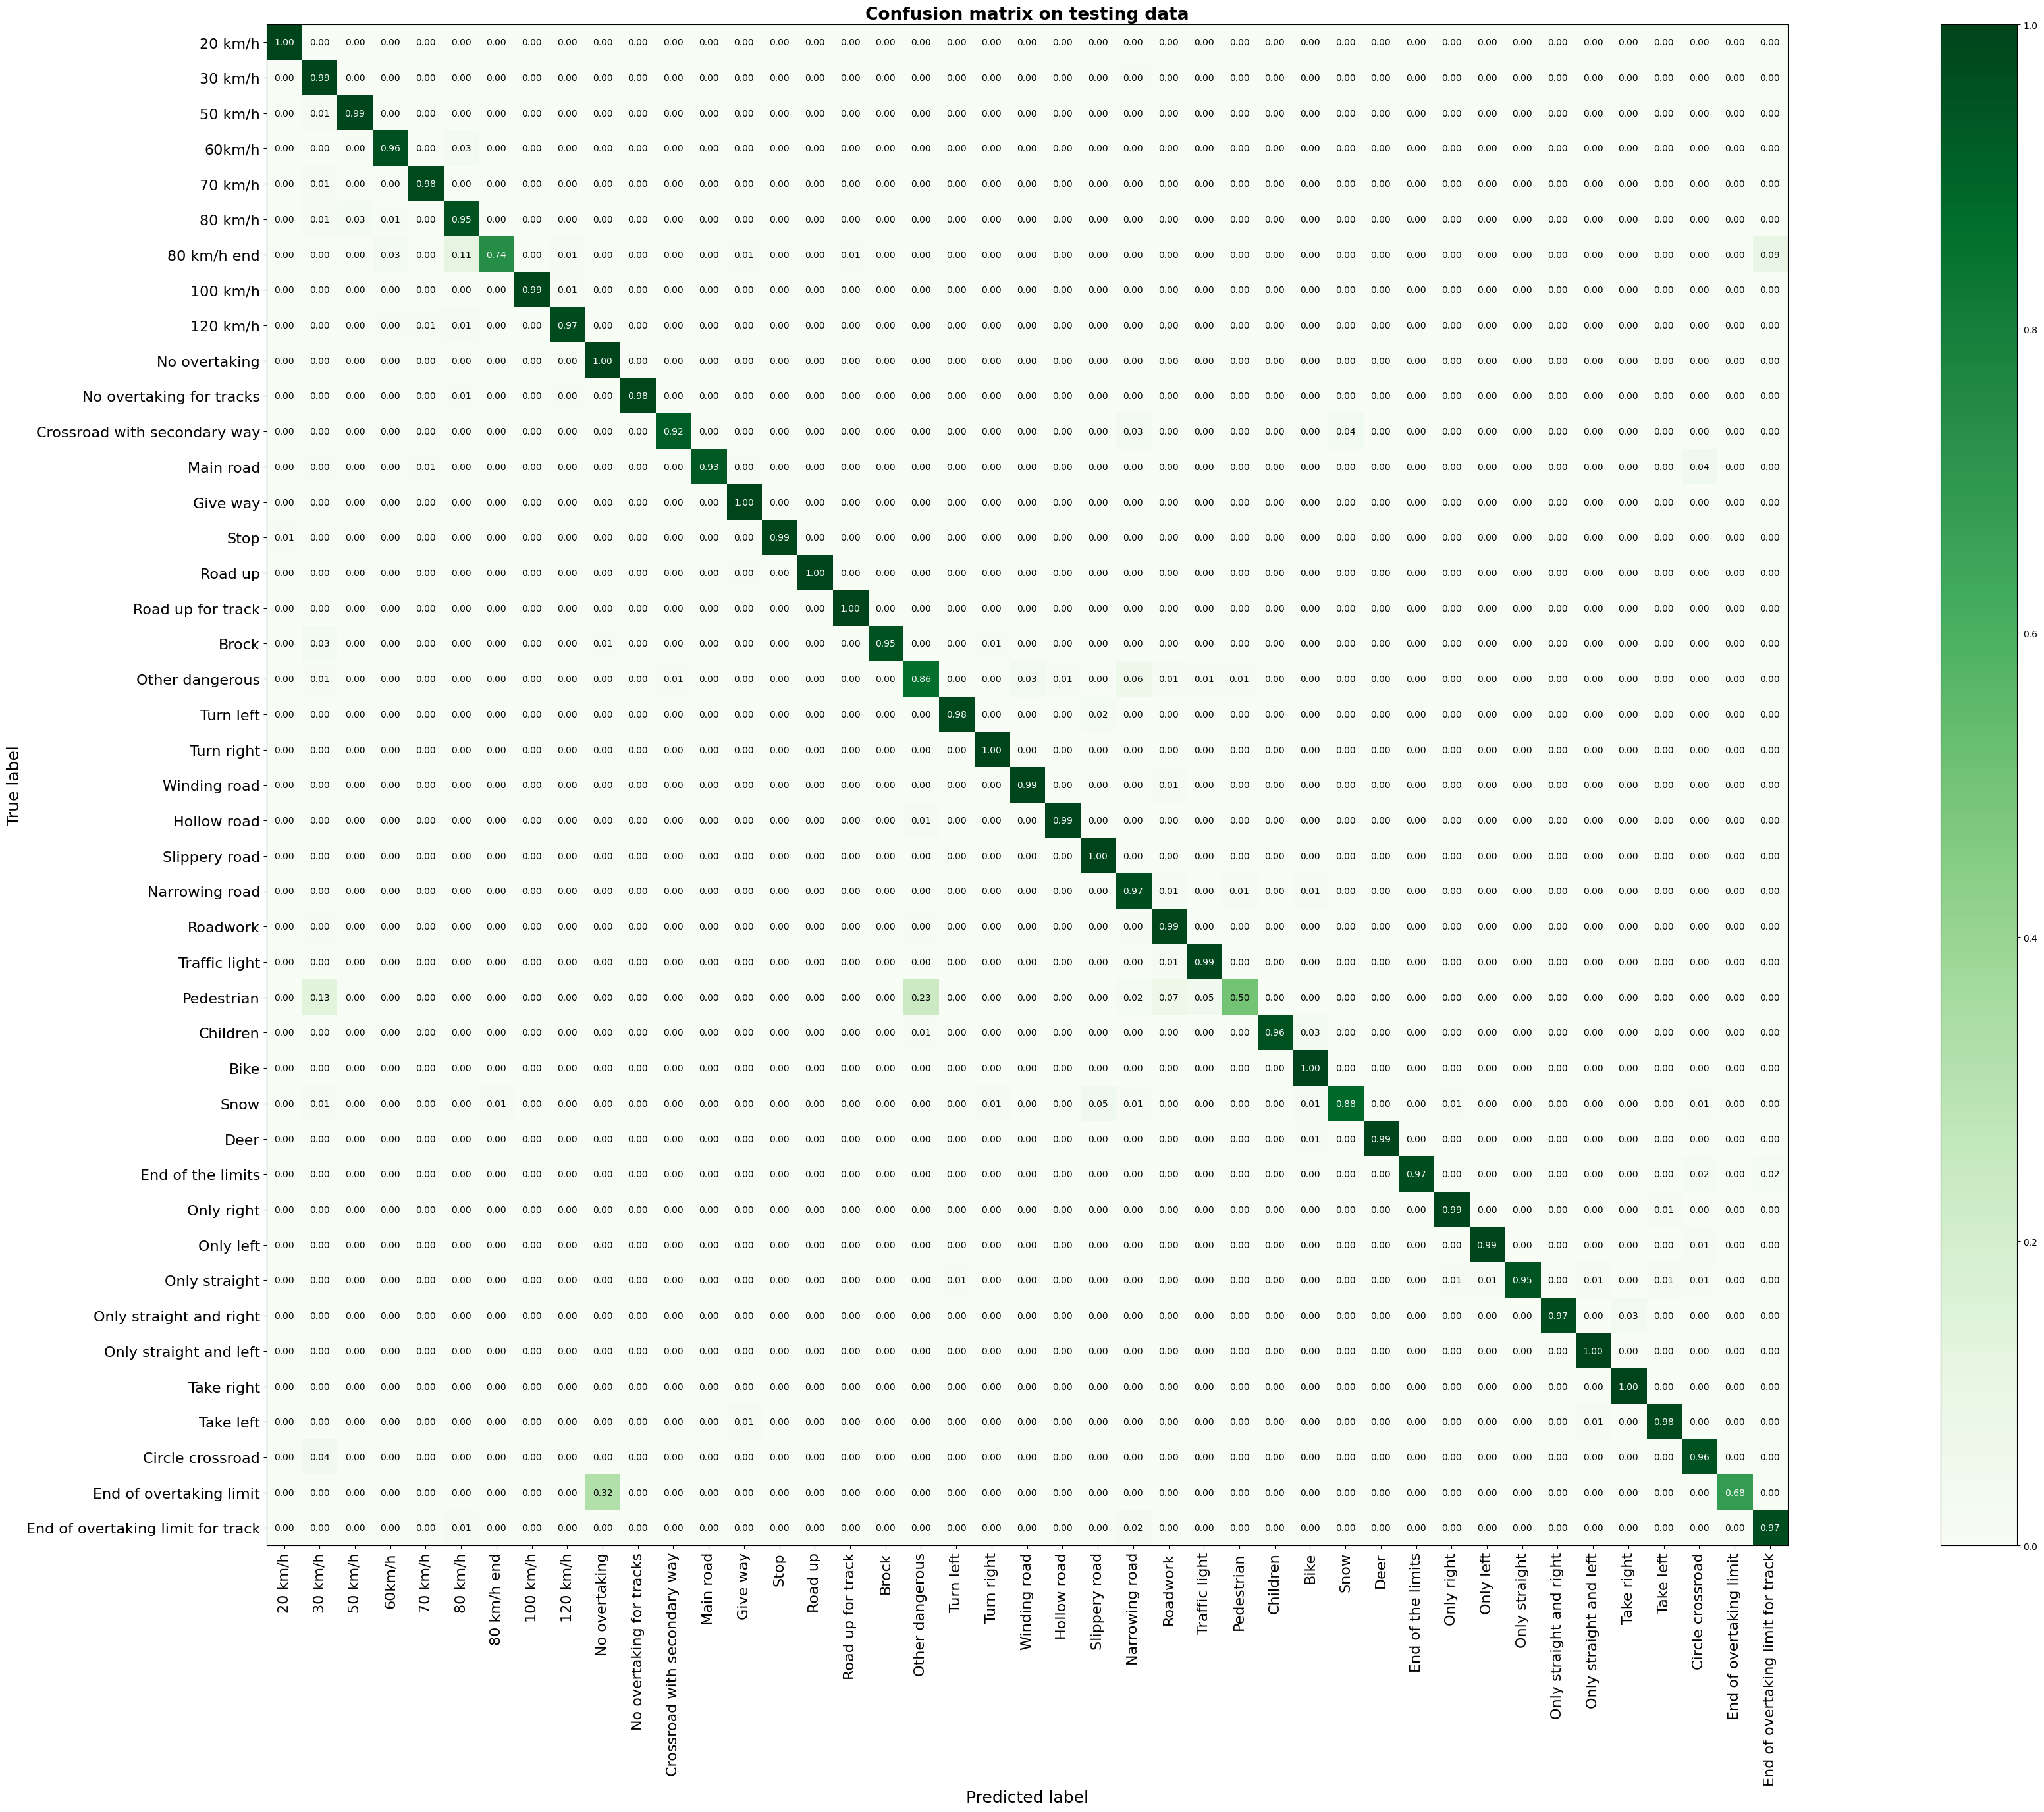

In [ ]:
train_cm = confusion_matrix(y_target = labels,
                            y_predicted = pred,
                            binary = False)
plot_cm(train_cm, 'Confusion matrix on testing data')

Actual label:  Main road
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Predicted label:  Main road


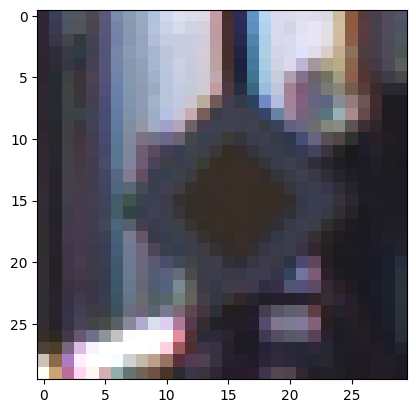

In [ ]:
x = 10
image_path = testDF['c_path'].tolist()[x]
data = []
image = Image.open(image_path)
image = image.resize((30, 30))
image = np.array(image)
plt.imshow(image)
print("Actual label: ", ac_labels[int(testDF.iloc[x,6])])
data.append(image)

data = np.array(data)
pred_prob = model.predict(data)
pred = np.argmax(pred_prob)
print("Predicted label: ", ac_labels[int(pred)])